# Libraries

In [202]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import nltk
from nltk.util import ngrams
from nltk import word_tokenize

# from nltk.corpus import stopwords
# stop_words = stopwords.words('english')
import warnings

import gensim
import gensim.corpora as corpora
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim as gensimvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaMulticore
from collections import Counter
from itertools import chain

# from sklearn.pipeline import Pipeline
# from imblearn.pipeline import Pipeline

# import matplotlib.ticker as ticker
# import matplotlib.ticker as mtick

from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict  # For word frequency
from textblob import TextBlob


# spacy for lemmatization
import spacy
nlp = spacy.load('en_core_web_lg')

# Sklearn
# from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
# from sklearn.model_selection import GridSearchCV
# from pprint import pprint


# libraries for visualization

import pickle

pd.set_option("max_rows", 1000)
pd.set_option('display.width', None)
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', 200)
warnings.filterwarnings("ignore",category=DeprecationWarning)



In [203]:
with open('df_reviews.pickle', 'rb') as f:
    df_reviews = pickle.load(f)

with open('df_reviews_P.pickle', 'rb') as f:
    df_reviews_P = pickle.load(f)


with open('df_reviews_N.pickle', 'rb') as f:
    df_reviews_N = pickle.load(f)


In [204]:
# df_reviews_Find = df_reviews[df_reviews['TextClean4'].str.contains(" omg ")][['Text','TextClean4']]
# df_reviews_Find

# Support Functions

In [205]:
def create_DictionaryAndDocTermMatrix (df_review_Col):
    doc_clean_tokenized_Lem = [review.split() for review in df_review_Col]
    corpus_dictionary = Dictionary(doc_clean_tokenized_Lem)
    doc_term_matrix = [corpus_dictionary.doc2bow(doc, allow_update=True) for doc in doc_clean_tokenized_Lem]
    tfidf  = TfidfModel(doc_term_matrix, smartirs='ntc',id2word=corpus_dictionary)
    doc_term_matrix_tfidf = tfidf[doc_term_matrix]
    return doc_clean_tokenized_Lem, corpus_dictionary, doc_term_matrix_tfidf

def createLDAFromTFIDF(corpus_tfidf, NumbOfTopics, corpus_dictionary):
    lda_model_tfidf = LdaMulticore(corpus_tfidf, num_topics=NumbOfTopics, 
                                   id2word=corpus_dictionary,
                                   
                                   minimum_probability=.3,  # -.4  best .2 so far, null nothing great, .6 notthing big
                                   
                                   random_state=100,
#                                    eval_every=15, #1 not good no better than leveling at default
                                   chunksize=50, #100, 15 not good, 50, 75, 100 - good, 300 - good but bad pyl

                                   #passes=30,
                                   passes=50,
                                   alpha='asymmetric', # 'asymmetric', 1 - really bad - 15 no better
                                   
                                   decay = .02, # .01, 1
                                   #per_word_topics=True, 
                                   #eta=1 #.01 or 1- not great
                                  )
    return lda_model_tfidf


def create_Lda_Models(doc_term_matrix_tfidf, doc_clean_tokenized_Lem, corpus_dictionary):
    #Create dataframe to house lDA Modles
    df_ModelInfo = pd.DataFrame(columns=["ModelName","Model", "NumberOfTopics", "Coherence"])
    #Set Lmits to Test & Evaluate Models
    limit=8; start=4; step=1;

    # LDAModles = ["ldaBOW", "ldatfidf", "ldaMallet"]
    LDAModles = ["ldatfidf"]
    # LDAModles = ["ldaBOW"]
    for ldaModel in LDAModles:

        #Create Models
        for num_topics in range(start, limit, step):
                df_ModelInfo = df_ModelInfo.append({'ModelName':ldaModel,'Model':createLDAFromTFIDF(doc_term_matrix_tfidf, num_topics,corpus_dictionary ), 'NumberOfTopics': num_topics} ,ignore_index = True)

        # Calculate & Collect Perplexity and Coherence Scores

        Coherence_values = []
        for index, row in df_ModelInfo.iterrows():
            coscore = evaluateCoherenceLDA(row["Model"], doc_clean_tokenized_Lem, corpus_dictionary)
            Coherence_values.append(coscore)

        df_ModelInfo["Coherence"] = Coherence_values
    return df_ModelInfo


def create_Lda_Models_short(doc_term_matrix_tfidf, doc_clean_tokenized_Lem, corpus_dictionary):
    #Create dataframe to house lDA Modles
    df_ModelInfo = pd.DataFrame(columns=["ModelName","Model", "NumberOfTopics", "Coherence"])
    #Set Lmits to Test & Evaluate Models
    limit=4; start=2; step=1;

    # LDAModles = ["ldaBOW", "ldatfidf", "ldaMallet"]
    LDAModles = ["ldatfidf"]
    # LDAModles = ["ldaBOW"]
    for ldaModel in LDAModles:

        #Create Models
        for num_topics in range(start, limit, step):
                df_ModelInfo = df_ModelInfo.append({'ModelName':ldaModel,'Model':createLDAFromTFIDF(doc_term_matrix_tfidf, num_topics,corpus_dictionary ), 'NumberOfTopics': num_topics} ,ignore_index = True)

        # Calculate & Collect Perplexity and Coherence Scores

        Coherence_values = []
        for index, row in df_ModelInfo.iterrows():
            coscore = evaluateCoherenceLDA(row["Model"], doc_clean_tokenized_Lem, corpus_dictionary)
            Coherence_values.append(coscore)

        df_ModelInfo["Coherence"] = Coherence_values
    return df_ModelInfo


def evaluateCoherenceLDA(ldaModelToEvaluate, doc_clean_tokenized_Lem, corpus_dictionary):
    #https://stackoverflow.com/questions/54762690/coherence-score-0-4-is-good-or-bad
    coherencemodel = CoherenceModel(model=ldaModelToEvaluate, texts=doc_clean_tokenized_Lem, dictionary=corpus_dictionary, coherence='c_v')
    Coherence = coherencemodel.get_coherence()
    return Coherence


def removelowfrequenceywords(doc_clean_tokenized, i):
    frequency = defaultdict(int)
    for text in doc_clean_tokenized:
        for token in text:
            frequency[token] += 1
    # Only keep words that appear more than ? insert
    doc_clean_tokenized = [[token for token in text if frequency[token] > i] for text in doc_clean_tokenized]
    
    return doc_clean_tokenized

def get_top_topic_per_review(ldamodel, corpus, texts):
    '''ldamodel = the current model, corpus = doc_term_matrix, text = ls_of_textToUse'''
    # Match reviews to dominate Topics
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[doc_term_matrix]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# Modeling

In [206]:
df_reviews_Find = df_reviews[df_reviews['TextClean4'].str.contains(" boca ")][['Text','TextClean4']]
# df_reviews_Fi
df_reviews_Find

,Text,TextClean4


## All Reviews

In [207]:
doc_clean_tokenized_Lem, corpus_dictionary, doc_term_matrix_tfidf,  = create_DictionaryAndDocTermMatrix(df_reviews["TextClean4"])
df_ModelInfo = create_Lda_Models(doc_term_matrix_tfidf, doc_clean_tokenized_Lem, corpus_dictionary)
df_ModelInfo

,ModelName,Model,NumberOfTopics,Coherence
0,ldatfidf,"LdaModel(num_terms=366, num_topics=4, decay=0.02, chunksize=50)",4,0.459288
1,ldatfidf,"LdaModel(num_terms=366, num_topics=5, decay=0.02, chunksize=50)",5,0.524011
2,ldatfidf,"LdaModel(num_terms=366, num_topics=6, decay=0.02, chunksize=50)",6,0.476567
3,ldatfidf,"LdaModel(num_terms=366, num_topics=7, decay=0.02, chunksize=50)",7,0.457514


In [208]:
print(f'Total Rows All Reviews Df: {len(df_reviews)}')
print(f'Total Rows All Reviews Token List: {len(doc_clean_tokenized_Lem)}')
# print(f'Total Rows All Reviews Dic: {len(corpus_dictionary_P)}')
print(f'Total Rows All Reviews TFIDF: {len(doc_term_matrix_tfidf)}')  

Total Rows All Reviews Df: 1816
Total Rows All Reviews Token List: 1816
Total Rows All Reviews TFIDF: 1816


In [239]:
# Select the model and print the topics
optimal_model = df_ModelInfo[(df_ModelInfo["ModelName"] == "ldatfidf") & (df_ModelInfo["NumberOfTopics"]==4)]["Model"].values[0]
optimal_model.print_topics()

[(0,
  '0.020*"like" + 0.019*"good" + 0.019*"meat" + 0.017*"taste" + 0.017*"vegan" + 0.016*"cook" + 0.016*"red_meat" + 0.016*"flavor" + 0.016*"price" + 0.016*"texture"'),
 (1,
  '0.082*"perfect" + 0.062*"recipe" + 0.050*"skeptical" + 0.043*"weird" + 0.038*"convenient" + 0.036*"smell_like" + 0.034*"aftertaste" + 0.032*"wait" + 0.027*"smell_bad" + 0.026*"continue"'),
 (2,
  '0.059*"realize" + 0.055*"crispy" + 0.046*"science" + 0.036*"fiber" + 0.027*"no_idea" + 0.026*"outside" + 0.025*"digest" + 0.025*"scare" + 0.024*"inside" + 0.023*"wonder"'),
 (3,
  '0.074*"oil" + 0.057*"water" + 0.057*"color" + 0.040*"body" + 0.035*"juice" + 0.028*"coconut" + 0.028*"unique" + 0.026*"contain" + 0.025*"vegetable" + 0.025*"break"')]

In [240]:
# Print Lda Vis
vis = gensimvis.prepare(optimal_model, doc_term_matrix_tfidf, corpus_dictionary, mds="mmds", R=10) #mds="tsne"
pyLDAvis.display(vis)

In [211]:
output_file = open("df_ModelInfo.pickle", "wb")
pickle.dump(df_ModelInfo, output_file)
output_file.close()

output_file1 = open("doc_term_matrix_tfidf.pickle", "wb")
pickle.dump(doc_term_matrix_tfidf, output_file1)
output_file1.close()

### K-means Analysis Negative

In [212]:
# https://towardsdatascience.com/k-means-clustering-chardonnay-reviews-using-scikit-learn-nltk-9df3c59527f3
from sklearn.cluster import KMeans
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans


# doc_clean_tokenized_Lem = [review.split() for review in df_reviews["TextClean3"]]
# doc_tokenized = [review.split() for review in df_reviews["Text"]]

df = pd.DataFrame()
#  split_text = " ".join(split_text)
#  clean_desc.append(split_text)

ls_of_texts = df_reviews.TextClean4.values.tolist()
clean_desc = []

clean_desc = ls_of_texts
#TF-IDF vectorizer
tfv = TfidfVectorizer(ngram_range = (1,1))
#transform
vec_text = tfv.fit_transform(clean_desc)
#returns a list of words.
words = tfv.get_feature_names()

#setup kmeans clustering
kmeans = KMeans(n_clusters = 7, n_init = 17, n_jobs = -1, tol = 0.01, max_iter = 200)
#fit the data 
kmeans.fit(vec_text)
#this loop transforms the numbers back into words
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))
    
#add the cluster label to the data frame
df['cluster'] = kmeans.labels_
clusters = df.groupby(['cluster']).size()

C:\Users\rgpih\anaconda3a\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


0 : bad, smell, cook, meat, taste, like, pet, good, food, texture
1 : beef, good, taste, like, substitute, cook, texture, taste_like, similar, flavor
2 : family, good, like, meat, tell, difference, taste, easy, health, recommend
3 : meat, good, taste, like, substitute, taste_like, texture, recommend, similar, flavor
4 : good, cook, taste, easy, barbecue, meat, can, texture, flavor, vegetarian
5 : vegan, good, meat, taste, vegetarian, like, family, substitute, no, recommend
6 : red_meat, like, good, taste, texture, cook, meat, taste_like, surprise, substitute


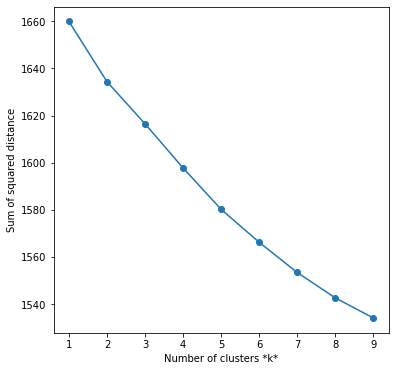

In [213]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(vec_text)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

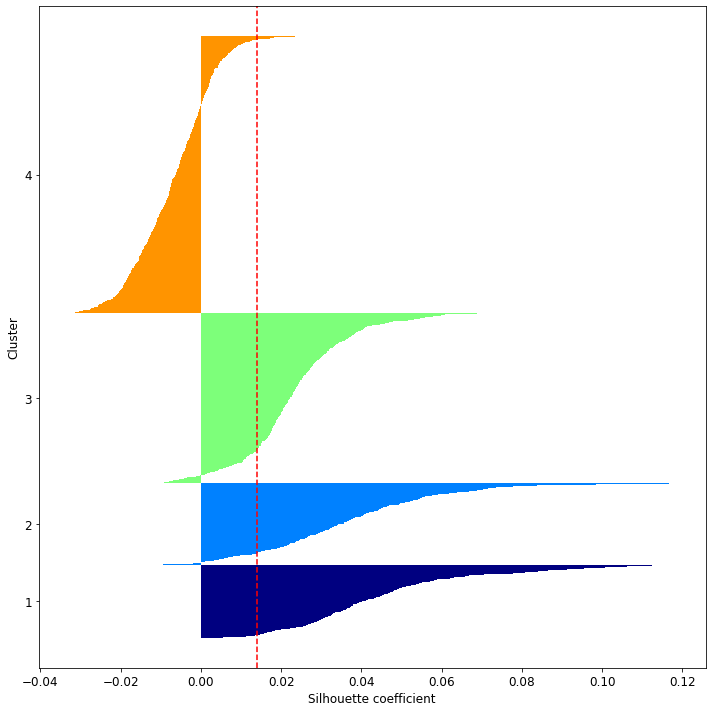

In [214]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm
import numpy as np
X = vec_text
km = KMeans(n_clusters=4, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)


fig, ax = plt.subplots(figsize=(10,10))
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1, fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.xlabel('Silhouette coefficient',fontsize=12)

plt.tight_layout()
#plt.savefig('images/11_04.png', dpi=300)
plt.show()


In [215]:
# <!-- Quantifying the quality of clustering via silhouette plots
# Silhouette score for a set of sample data points is used to measure how dense and well-separated the clusters are.
# Silhouette score takes into consideration the intra-cluster distance between the sample and other data points within the same cluster (a) and inter-cluster distance between the sample and the next nearest cluster (b).
# The silhouette score falls within the range [-1, 1].
# The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect.
# The silhouette plots can be used to select the most optimal value of the K (no. of cluster) in K-means clustering.
# The aspects to look out for in Silhouette plots are cluster scores below the average silhouette score, wide fluctuations in the size of the clusters, and also the thickness of the silhouette plot. -->

## Positive Reviews

In [216]:
doc_clean_tokenized_Lem_P, corpus_dictionary_P, doc_term_matrix_tfidf_P,  = create_DictionaryAndDocTermMatrix(df_reviews_P["TextClean4"])
df_ModelInfo_P = create_Lda_Models(doc_term_matrix_tfidf_P, doc_clean_tokenized_Lem_P, corpus_dictionary_P)
df_ModelInfo_P

,ModelName,Model,NumberOfTopics,Coherence
0,ldatfidf,"LdaModel(num_terms=366, num_topics=4, decay=0.02, chunksize=50)",4,0.497222
1,ldatfidf,"LdaModel(num_terms=366, num_topics=5, decay=0.02, chunksize=50)",5,0.497486
2,ldatfidf,"LdaModel(num_terms=366, num_topics=6, decay=0.02, chunksize=50)",6,0.557967
3,ldatfidf,"LdaModel(num_terms=366, num_topics=7, decay=0.02, chunksize=50)",7,0.546413


In [217]:
print(f'Total Rows All Reviews Df: {len(df_reviews_P)}')
print(f'Total Rows All Reviews Token List: {len(doc_clean_tokenized_Lem_P)}')
# print(f'Total Rows All Reviews Dic: {len(corpus_dictionary_P)}')
print(f'Total Rows All Reviews TFIDF: {len(doc_term_matrix_tfidf_P)}')  

Total Rows All Reviews Df: 1512
Total Rows All Reviews Token List: 1512
Total Rows All Reviews TFIDF: 1512


In [237]:
# Select the model and print the topics
optimal_model_P = df_ModelInfo_P[(df_ModelInfo_P["ModelName"] == "ldatfidf") & (df_ModelInfo_P["NumberOfTopics"]==4)]["Model"].values[0]
optimal_model_P.print_topics()

[(0,
  '0.021*"meat" + 0.020*"like" + 0.018*"taste" + 0.018*"family" + 0.017*"good" + 0.016*"vegan" + 0.015*"red_meat" + 0.015*"beef" + 0.015*"cook" + 0.014*"substitute"'),
 (1,
  '0.065*"quality" + 0.054*"high" + 0.027*"leave" + 0.027*"inexpensive" + 0.024*"stomach" + 0.024*"finally" + 0.023*"crispy" + 0.023*"impressed" + 0.022*"chemical" + 0.020*"pork"'),
 (2,
  '0.077*"size" + 0.040*"cruelty" + 0.034*"exceededed" + 0.027*"issue" + 0.024*"worry" + 0.022*"break" + 0.016*"win" + 0.016*"read" + 0.014*"sorry" + 0.014*"section"'),
 (3,
  '0.084*"convenient" + 0.036*"smell_bad" + 0.034*"shape" + 0.030*"guilt" + 0.024*"guilt_free" + 0.021*"hype" + 0.017*"small" + 0.010*"feed" + 0.006*"contain" + 0.006*"body"')]

In [219]:
df_reviews_Find = df_reviews_P[df_reviews_P['TextClean4'].str.contains(" frozen ")][['Text','TextClean4']]
# df_reviews_Fi
df_reviews_Find

,Text,TextClean4


In [220]:
# Print Lda Vis
vis = gensimvis.prepare(optimal_model_P, doc_term_matrix_tfidf_P, corpus_dictionary_P, mds="mmds", R=10) #mds="tsne"
pyLDAvis.display(vis)

In [221]:
output_file = open("df_ModelInfo_P.pickle", "wb")
pickle.dump(df_ModelInfo_P, output_file)
output_file.close()

output_file1 = open("doc_term_matrix_tfidf_P.pickle", "wb")
pickle.dump(doc_term_matrix_tfidf_P, output_file1)
output_file1.close()

### K-means Analysis Negative

In [222]:
# https://towardsdatascience.com/k-means-clustering-chardonnay-reviews-using-scikit-learn-nltk-9df3c59527f3
from sklearn.cluster import KMeans
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans


# doc_clean_tokenized_Lem = [review.split() for review in df_reviews["TextClean3"]]
# doc_tokenized = [review.split() for review in df_reviews["Text"]]

df = pd.DataFrame()
#  split_text = " ".join(split_text)
#  clean_desc.append(split_text)

ls_of_texts = df_reviews_P.TextClean4.values.tolist()
clean_desc = []

clean_desc = ls_of_texts
#TF-IDF vectorizer
tfv = TfidfVectorizer(ngram_range = (1,1))
#transform
vec_text = tfv.fit_transform(clean_desc)
#returns a list of words.
words = tfv.get_feature_names()

#setup kmeans clustering
kmeans = KMeans(n_clusters = 7, n_init = 17, n_jobs = -1, tol = 0.01, max_iter = 200)
#fit the data 
kmeans.fit(vec_text)
#this loop transforms the numbers back into words
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))
    
#add the cluster label to the data frame
df['cluster'] = kmeans.labels_
clusters = df.groupby(['cluster']).size()

C:\Users\rgpih\anaconda3a\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


0 : can, good, meat, taste, like, cook, health, barbecue, red_meat, texture
1 : meat, good, like, taste, substitute, taste_like, texture, cook, health, recommend
2 : red_meat, good, taste, like, surprise, texture, cook, taste_like, similar, meat
3 : family, good, meat, like, tell, taste, difference, easy, recommend, health
4 : vegan, good, meat, taste, vegetarian, like, substitute, family, recommend, red_meat
5 : good, cook, meat, easy, taste, barbecue, like, flavor, no, vegetarian
6 : beef, good, taste, like, substitute, cook, texture, taste_like, family, red_meat


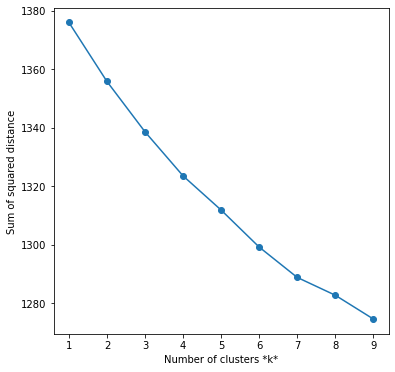

In [223]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(vec_text)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [224]:
# reviewsContaining = df_reviews[df_reviews['TextClean3'].str.contains(' cause ')]
# reviewsContaining[['Text','TextClean','TextClean3']]

## Negative Reviews

In [225]:
doc_clean_tokenized_Lem_N, corpus_dictionary_N, doc_term_matrix_tfidf_N,  = create_DictionaryAndDocTermMatrix(df_reviews_N["TextClean4"])
df_ModelInfo_N = create_Lda_Models_short(doc_term_matrix_tfidf_N, doc_clean_tokenized_Lem_N, corpus_dictionary_N)
df_ModelInfo_N

,ModelName,Model,NumberOfTopics,Coherence
0,ldatfidf,"LdaModel(num_terms=292, num_topics=2, decay=0.02, chunksize=50)",2,0.603598
1,ldatfidf,"LdaModel(num_terms=292, num_topics=3, decay=0.02, chunksize=50)",3,0.689918


In [226]:
# Select the model and print the topics
optimal_model_N = df_ModelInfo_N[(df_ModelInfo_N["ModelName"] == "ldatfidf") & (df_ModelInfo_N["NumberOfTopics"]==2)]["Model"].values[0]
optimal_model_N.print_topics()

[(0,
  '0.017*"bad" + 0.015*"smell" + 0.013*"good" + 0.013*"meat" + 0.012*"cook" + 0.012*"like" + 0.012*"pet" + 0.012*"red_meat" + 0.012*"food" + 0.011*"beef"'),
 (1,
  '0.004*"carb" + 0.004*"fill" + 0.003*"unhealth" + 0.003*"canola" + 0.003*"kill" + 0.003*"crumble" + 0.003*"size" + 0.003*"package" + 0.003*"compare" + 0.003*"household"')]

In [227]:
# Print Lda Vis
vis = gensimvis.prepare(optimal_model_N, doc_term_matrix_tfidf_N, corpus_dictionary_N, mds="mmds", R=10) #mds="tsne"
pyLDAvis.display(vis)

In [228]:
output_file = open("df_ModelInfo_N.pickle", "wb")
pickle.dump(df_ModelInfo_N, output_file)
output_file.close()

output_file1 = open("doc_term_matrix_tfidf_N.pickle", "wb")
pickle.dump(doc_term_matrix_tfidf_N, output_file1)
output_file1.close()

### K-means Analysis Negative

In [229]:
# https://towardsdatascience.com/k-means-clustering-chardonnay-reviews-using-scikit-learn-nltk-9df3c59527f3
from sklearn.cluster import KMeans
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans


# doc_clean_tokenized_Lem = [review.split() for review in df_reviews["TextClean3"]]
# doc_tokenized = [review.split() for review in df_reviews["Text"]]

df = pd.DataFrame()
#  split_text = " ".join(split_text)
#  clean_desc.append(split_text)

ls_of_texts = df_reviews_N.TextClean4.values.tolist()
clean_desc = []

clean_desc = ls_of_texts
#TF-IDF vectorizer
tfv = TfidfVectorizer(ngram_range = (1,1))
#transform
vec_text = tfv.fit_transform(clean_desc)
#returns a list of words.
words = tfv.get_feature_names()

#setup kmeans clustering
kmeans = KMeans(n_clusters = 7, n_init = 17, n_jobs = -1, tol = 0.01, max_iter = 200)
#fit the data 
kmeans.fit(vec_text)
#this loop transforms the numbers back into words
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))
    
#add the cluster label to the data frame
df['cluster'] = kmeans.labels_
clusters = df.groupby(['cluster']).size()

0 : meat, beef, taste_like, flavor, bad, cook, taste, hard, substitute, good
1 : pet, food, smell_like, bad, smell, like, time, expensive, taste, cook
2 : bad, smell, cook, good, taste_bad, time, red_meat, open, aftertaste, away
3 : like, red_meat, food, taste, meat, texture, good, can, smell, vegetarian
4 : fat, salt, health, vegan, nutrition, save, like, can, meat, read
5 : smell_bad, chili, grease, bad, high, red_meat, taste, recipe, seasoning, spice
6 : bad, good, meat, oil, price, like, no, canola, vegetarian, juice


C:\Users\rgpih\anaconda3a\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


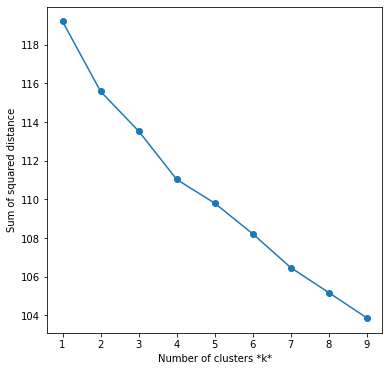

In [230]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(vec_text)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

#### Get Topic Words

In [ ]:
# Get Topic words into dataframe
df_all = pd.DataFrame()
for topic_idx, topic in enumerate(optimal_model.show_topics(formatted=False)):
    df = pd.DataFrame(topic[1], columns =['word', 'Percent'])
    df['Topic'] = topic_idx
    df_all = df_all.append(df)

df_all['Percent'] = df_all['Percent'].astype(float).round(2)
# df_all


# # Additional Misc ways to view in df format
#     df_Currtopic = df_all[df_all['Topic']==2]
#     df_Currtopic = df_Currtopic.sort_values(by="Percent", ascending=False)
#     curTopic_CS = pd.crosstab(df_Currtopic.Topic,df_Currtopic.word, values=df_Currtopic.Percent, aggfunc='max').round(2).reset_index()
#     df_Currtopic

In [ ]:
df_all

In [ ]:
df_allTopicWord =df_all[['word','Topic']]

In [ ]:
# df_all["word"].groupby.count()
df_all['word1'] = df_all['word']
dfall1 = df_all.groupby(['word'])['word1'].count()
df_wordCount = dfall1.to_frame().reset_index()
df_wordCount.columns=["word", "count"]
df_wordCount = df_wordCount.sort_values(by="count", ascending=False)
df_wordCount
df_allTopicWord = df_all[["word","Topic"]]
df_wordCount = df_wordCount.merge(df_allTopicWord, on="word")
df_wordCount
# df_all_Crosstab = pd.crosstab(df_wordCount.Topic,df_wordCount.word, values=df_wordCount.word, aggfunc='count')
# df_all_Crosstab.sort_values('count', ascending=False)

In [ ]:
# Get Topic words into crosstab
df_all_Crosstab = pd.crosstab(df_all.Topic,df_all.word, values=df_all.Percent, aggfunc='max').round(2)

# # Misc additional Crosstab views
#     dfall1 = df_all.groupby(['Topic','word'])['Percent'].max().unstack().fillna(0).round(2).reset_index()
#     dfall1
#     dfall2 = df_all.groupby(['Topic','word'])['Percent'].max().unstack().fillna(0).round(2)
#     dfall2